<img src="images/GCM_logo.png" width=250 alt="GCM Logo"></img>

# MITgcm MOM6 Example

Next, title your notebook appropriately with a top-level Markdown header, `#`. Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

# MITgcm MOM6 Example

Next, title your notebook appropriately with a top-level Markdown header, `#`. Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

---

## MOM6 Overview

1. MOM6 variables are staggered according to the Arakawa C-grid
1. It uses a north-east index convention
1. Center points are labelled (xh, yh) and corner points are labelled (xq, yq)
1. Important: variables xh/yh, xq/yq that are named "nominal" longitude/latitude are not the true geographical coordinates and are not suitable for plotting (more later)

## Prerequisites

In this notebook, you will learn to use Cartopy, Matplotlib, and Xarray to extract and plot MOM6 data in the Python Ecosystem. Below you will find some links to other Project Pythia resources that may be helpful for understanding this notebook.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| -- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
First, we will begin by importing all necessary packages for this notebook. In the following cell, you will see a list of import statements from various packages. If your local environment does not have the required package, you will get a `ModuleNotFoundError` message followed by the module (package) you do not have installed. To resolve this, simply use conda in your terminal window to install the required package to your environment and then re-run the cell.

In [4]:
import xarray as xr
from xgcm import Grid
import warnings
import matplotlib.pylab as plt
from cartopy import crs as ccrs

This next call will ensure all of your Matplotlib projects will display in the Jupyter Notebook when they are run.

In [5]:
%matplotlib inline
warnings.filterwarnings("ignore")
_ = xr.set_options(display_style='text')

## Read in Dataset
For this tutorial, we use sample data for the 1/2 degree global model OM4p05 hosted on a GFDL thredds server:

Use Xarray to open website where netCDF4 dataset can be taken from and assign it to the variable `ds`. Then print `ds` to ensure the dataset was read successfully and to explore the data inside the file.

In [6]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1},
                     drop_variables=['average_DT',
                                     'average_T1',
                                     'average_T2'],
                     engine='netcdf4')
print(ds)

<xarray.Dataset>
Dimensions:       (nv: 2, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35,
                   time: 60)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables: (12/36)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=n

When looking at the dataset print out, you should see a couple of fields populated that imply the dataset was read in correctly and populated. First, we know we are looking for data variables of `xh`, `yh`, `xq`, and `yq`, which are all present. The next is that the dataset is actually populated and not empty. To verify this, we can look at either the values next to the data variables listed under `Dimensions` or we can look at the values next to the variables listed under `Coordinates`. For both of these routes, you want to ensure the value is either non-zero under `Dimensions` and that the values under `Coordinates` are sensical (i.e. not -9999999, span a reasonable range of values, etc).

### xgcm Grid Definition

The horizontal dimensions are a combination of (xh or xq) and (yh or yq) corresponding to the staggered point. In the vertical z_l refers to the depth of the center of the layer and z_i to the position of the interfaces, such as len(z_i) = len(z_l) +1.

the geolon/geolat family are the TRUE geographical coordinates and are the longitude/latitude you want to use to plot results. The subscript correspond to the staggered point (c: corner, u: U-point, v: V-point, no subscript: center)

the areacello family is the area of the ocean cell at various points with a slightly naming convention (bu: corner, cu: U-point, cv: V-point, no subscript: center). Warning, because of the curvilinear grid:


the dx/dy family has the following naming convention: dx(Cu: U-point, Cv: V-point, no suffix: center)

thkcello is the layer thickness for each cell (variable). volcello is the volume of the cell, such as:


The MOM6 output can be written in Symetric (len(Xq) = len(Xh) + 1) or Non-symetric mode (len(Xq) = len(Xh)), where X is a notation for both x and y. In Symetric mode, one would define the grid for the global as:

grid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'inner': 'z_l', 'outer': 'z_i'} }, periodic=['X'])
and in Non-symetric mode:

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'inner': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

Of course, don't forget to drop the periodic option if you're running a regional model. Our data is written in Non-symetric mode hence:

In [7]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'inner': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

### A note on geographical coordinates
MOM6 uses land processor elimination, which creates blank holes in the produced geolon/geolat fields. This can result in problems while plotting. It is recommended to overwrite them by the full arrays that are produced by running the model for a few steps without land processor elimination. Here we copy one of these files.

In [8]:
!curl -O https://raw.githubusercontent.com/raphaeldussin/MOM6-AnalysisCookbook/master/docs/notebooks/data/ocean_grid_sym_OM4_05.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6512k  100 6512k    0     0  17.1M      0 --:--:-- --:--:-- --:--:-- 17.0M


In [9]:
!ncdump -h ocean_grid_sym_OM4_05.nc

netcdf ocean_grid_sym_OM4_05 {
dimensions:
	yh = 576 ;
	xh = 720 ;
	yq = 577 ;
	xq = 721 ;
variables:
	float geolat(yh, xh) ;
		geolat:long_name = "Latitude of tracer (T) points" ;
		geolat:units = "degrees_north" ;
		geolat:missing_value = 1.e+20f ;
		geolat:_FillValue = 1.e+20f ;
		geolat:cell_methods = "time: point" ;
	float geolat_c(yq, xq) ;
		geolat_c:long_name = "Latitude of corner (Bu) points" ;
		geolat_c:units = "degrees_north" ;
		geolat_c:missing_value = 1.e+20f ;
		geolat_c:_FillValue = 1.e+20f ;
		geolat_c:cell_methods = "time: point" ;
		geolat_c:interp_method = "none" ;
	float geolon(yh, xh) ;
		geolon:long_name = "Longitude of tracer (T) points" ;
		geolon:units = "degrees_east" ;
		geolon:missing_value = 1.e+20f ;
		geolon:_FillValue = 1.e+20f ;
		geolon:cell_methods = "time: point" ;
	float geolon_c(yq, xq) ;
		geolon_c:long_name = "Longitude of corner (Bu) points" ;
		geolon_c:units = "degrees_east" ;
		geolon_c:missing_value = 1.e+20f ;
		geolon_c:_FillValue = 1.e+

In [10]:
ocean_grid_sym = xr.open_dataset('ocean_grid_sym_OM4_05.nc')

print(ocean_grid_sym)

<xarray.Dataset>
Dimensions:   (yh: 576, xh: 720, yq: 577, xq: 721)
Coordinates:
  * xh        (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq        (xq) float64 -300.0 -299.5 -299.0 -298.5 ... 58.5 59.0 59.5 60.0
  * yh        (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq        (yq) float64 -78.0 -77.82 -77.63 -77.45 ... 89.37 89.58 89.79 90.0
Data variables:
    geolat    (yh, xh) float32 ...
    geolat_c  (yq, xq) float32 ...
    geolon    (yh, xh) float32 ...
    geolon_c  (yq, xq) float32 ...
Attributes:
    filename:   19000101.ocean_static.nc
    title:      OM4_SIS2_cgrid_05
    grid_type:  regular
    grid_tile:  N/A
    history:    Tue Mar  3 13:41:58 2020: ncks -v geolon,geolon_c,geolat,geol...
    NCO:        4.0.3


Here we use a symetric grid to highlight the differences with the non-symetric. Since MOM6 uses the north-east convention, we can obtain the non-symetric grid from the symetric by removing the first row and column in our arrays. This overwrites our "gruyere" coordinates in our Non-symetric dataset:

In [11]:
ds['geolon_c'] = xr.DataArray(data=ocean_grid_sym['geolon_c'][1:,1:], dims=('yq', 'xq'))
ds['geolat_c'] = xr.DataArray(data=ocean_grid_sym['geolat_c'][1:,1:], dims=('yq', 'xq'))

ds['geolon'] = xr.DataArray(data=ocean_grid_sym['geolon'], dims=('yh', 'xh'))
ds['geolat'] = xr.DataArray(data=ocean_grid_sym['geolat'], dims=('yh', 'xh'))

## Vorticity computation
Now we can do some computations with the data. Here we will use the vorticity equation from the MITgcm example and adapt it for MOM6

In [12]:
vorticity = ( - grid.diff(ds.uo * ds.dxCu, 'Y', boundary='fill')
              + grid.diff(ds.vo * ds.dyCv, 'X', boundary='fill') ) / ds.areacello_bu

print(vorticity)

<xarray.DataArray (time: 60, z_l: 35, yq: 576, xq: 720)>
dask.array<truediv, shape=(60, 35, 576, 720), dtype=float32, chunksize=(1, 1, 575, 719), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0


Now we will look at the surface relative vorticity at the first time record. Note, we select `time=0` as the indexing in this dataset is "0 based" meaning the first value in an array will be "0" and not "1".

In [13]:
data_plot = 1e5 * vorticity.isel(time=0, z_l=0)
_ = data_plot.load()

## Plotting the Data

Now we will use our dataset with cartopy and matplotlib to create a map projection of the data. Here we want to be careful and make sure we use the right set of coordinates (geolon_c/geolat_c). Since they are not present in the DataArray, we can add them easily with:

In [14]:
data_plot = data_plot.assign_coords({'geolon_c': ds['geolon_c'],
                                     'geolat_c': ds['geolat_c']})

One thing worth noting is that geolon_c is not monotonic in the uppermost row. Hence this row needs to be removed for cartopy to properly plot. Another option is to subsample x in the MOM6 supergrid, usually named ocean_hgrid.nc.

In [15]:
data_plot = data_plot.isel(xq=slice(0,-1), yq=slice(0,-1))

Now let's define a function that will produce a publication-quality plot:

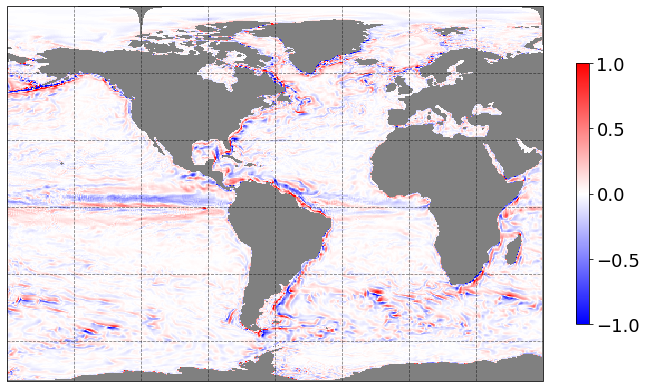

In [16]:
# Define kwargs for the plot
subplot_kws=dict(projection=ccrs.PlateCarree(), # Map projection to be used
                 facecolor='grey') # facecolor of land

plt.figure(figsize=[12,8])
p = data_plot.plot(x='geolon_c',
                   y='geolat_c',
                   vmin=-1,
                   vmax=1,
                   cmap='bwr', # Color map to use for data
                   subplot_kws=subplot_kws,
                   transform=ccrs.PlateCarree(), # Different than 'projection', tells Cartopy info about spacial data
                   add_labels=False,
                   add_colorbar=False) # Removes auto-colorbar

# add separate colorbar
cb = plt.colorbar(p, ticks=[-1,-0.5,0,0.5,1], shrink=0.6) # Manually adds colorbar to plot
cb.ax.tick_params(labelsize=18) # Edit tick labels for map projection

# Optional add grid lines
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

---

## Summary
From this notebook, you learned how to read in a netCDF file using Xarray, validate the dataset, select data from the dataset, compute the vorticity of the data, then use Matplotlib and Cartopy to plot the data on a PlateCarree map projection. 

## Resources and references

For more information and further GCM examples, please visit the [GCM examples library](http://gallery.pangeo.io/repos/xgcm/xgcm-examples/). Or, follow along with [Project Pythia's Cookbooks](https://github.com/ProjectPythiaCookbooks/xgcm-cookbook).


## Resources and references

For more information and further GCM examples, please visit the [GCM examples library](http://gallery.pangeo.io/repos/xgcm/xgcm-examples/). Or, follow along with [Project Pythia's Cookbooks](https://github.com/ProjectPythiaCookbooks/xgcm-cookbook).
